# Clarins challenge: data modelling

Gabriel Delgado
gndelgad@gmail.com
06/03/2020

Create an algorithm to realize the order forecast of this dataset:
https://www.kaggle.com/janusznoszczynski/polish-pizza-restaurants-orders-history

## Imports

In [3]:
import pandas as pd
from datetime import date as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

In [4]:
df_data = pd.read_csv('pizzeria_tania_data_simplified.csv')

In [5]:
df_data.head(2)

,count,year,month,day,hour,working_day,weekend_day,public_holiday
0,5,2016,10,11,12,1,0,0
1,1,2016,10,11,13,1,0,0


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772 entries, 0 to 14771
Data columns (total 8 columns):
count             14772 non-null int64
year              14772 non-null int64
month             14772 non-null int64
day               14772 non-null int64
hour              14772 non-null int64
working_day       14772 non-null int64
weekend_day       14772 non-null int64
public_holiday    14772 non-null int64
dtypes: int64(8)
memory usage: 923.3 KB


## Data cleaning and sanity checks

In [6]:
# There are no missing values
pd.isnull(df_data).sum()

count             0
year              0
month             0
day               0
hour              0
working_day       0
weekend_day       0
public_holiday    0
dtype: int64

In [26]:
# Always at least one of the three cases must occur but not the three at the same time
all((df_data['working_day'] + df_data['weekend_day'] + df_data['public_holiday']).isin({1, 2}))

True

In [29]:
# sanity check on numerical features: all variables belong to the expected intervals
df_data.describe()

,count,year,month,day,hour,working_day,weekend_day,public_holiday
count,14772.000000,14772.000000,14772.000000,14772.000000,14772.000000,14772.000000,14772.000000,14772.000000
mean,4.255890,2017.143109,6.258327,15.704373,11.499594,0.686637,0.285879,0.040482
std,5.968123,0.622044,3.657908,8.739027,6.922108,0.463876,0.451847,0.197093
min,0.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2017.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000
50%,0.000000,2017.000000,6.000000,16.000000,12.000000,1.000000,0.000000,0.000000
75%,8.000000,2018.000000,10.000000,23.000000,17.000000,1.000000,1.000000,0.000000
max,35.000000,2018.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000


## Adding more features

We will just add the weekday day from the date. Monday is 0 and Sunday is 6.

In [7]:
df_data['weekday'] = df_data.apply(lambda row: dt(row.year, row.month, row.day).weekday(), axis=1)

## Splitting dataset into training and test

In [8]:
df_data_train, df_data_test = train_test_split(df_data, test_size=0.2, random_state=42)

In [9]:
print('Percentage of instances in the test set: %s'%(len(df_data_test) / len(df_data)))

Percentage of instances in the test set: 0.20004061738424045


## Feature pre-analysis 

We isolate the test set and we perform a pre-analysis on the training dataset features.

### Hour analysis

We observe that for hour < 11 the average count order is almost equal to 0 (the pizza restaurant is closed between 0am and 8am and then between 9am and 11am there are very few orders).

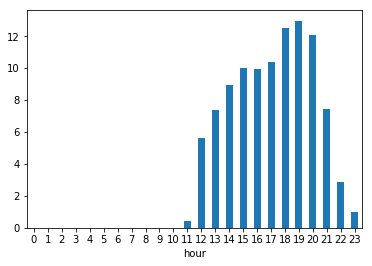

In [102]:
_ = df_data_train.groupby(by='hour').mean()['count'].plot.bar(rot=0)

In [59]:
all(df_data_train[df_data_train['hour'].isin({1, 2, 3, 4, 5, 6, 7, 8})]['count'] == 0)

True

In [99]:
len(df_data_train[(df_data_train['hour'].isin({9, 10})) & (df_data_train['count'] > 0)])

5

In [105]:
df_data_train[(df_data_train['hour'].isin({11})) & (df_data_train['count'] > 0)]['count'].mean()

1.6370967741935485

### Year analysis

Since this a forecasting model to be used in the current year, we will not use the year feature as predictor. That being said, we can note that the average number of orders (count) is almost constant among different years.

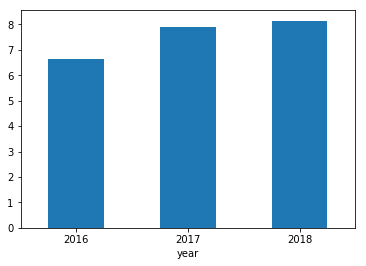

In [110]:
_ = df_data_train.groupby(by='year').mean()['count'].plot.bar(rot=0)

### Month analysis 

We observe some variability between months regarding the average count of orders. So as to avoid any induced order in the feature, we will consider each month as a categorical variable without any underlying order relation.

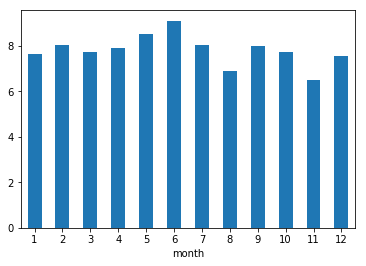

In [111]:
_ = df_data_train.groupby(by='month').mean()['count'].plot.bar(rot=0)

### Day analysis

As observed below the order count per day is quite variable where a certain periodicity is observed. However, this caracteristic is rather explained by the workday/weekend structure of every week since there is not much in common between two days through different months. It is of much more interest to take rather the weekday as a feature. As it can be observed, there is a clear difference between the count of orders depending of the day of the week that explains the observed periodic pattern.

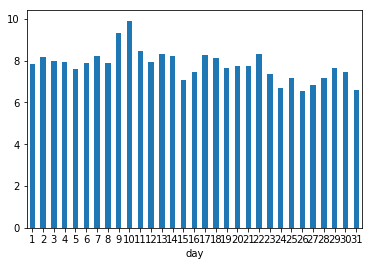

In [112]:
_ = df_data_train.groupby(by='day').mean()['count'].plot.bar(rot=0)

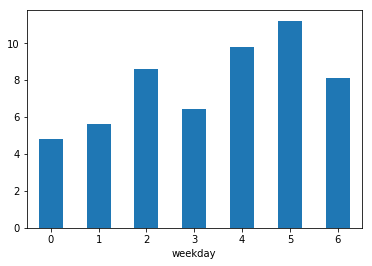

In [122]:
_ = df_data_train.groupby(by='weekday').mean()['count'].plot.bar(rot=0)

### Binary variables: public_holidays, working_day, weekend_day

From the boxplots, we observe that each combination of binary variable presents a different
average (in order to have a clear boxplot with median > 0 we filter the training instances for which we certainly know that the pizza store was closed). In particular the order count seems to be much larger during non-holidays weekends.

In [ ]:
df_data_train_filter_hours = df_data_train[~df_data_train['hour'].isin({1, 2, 3, 4, 5, 6,
                                                                        7, 8, 9, 10, 11})]

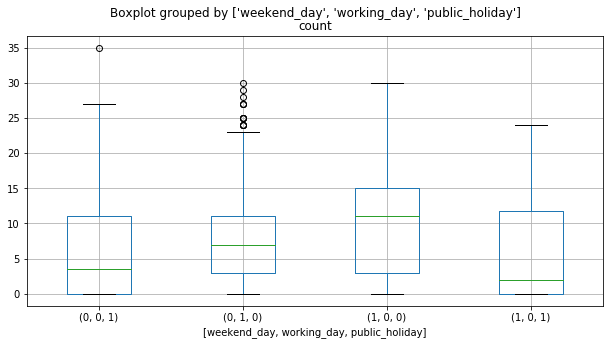

In [107]:
# (0, 0, 1) -> public holiday between Monday and Friday
# (1, 0, 1) -> public holiday between Saturday and Sunday
# (0, 1, 0) -> Working day 
# (1, 0, 0) -> Not public holiday weekend day 
_ = df_data_train_filter_hours.boxplot(column='count', by=['weekend_day',
                                                           'working_day',
                                                           'public_holiday'],
                                       figsize=(10, 5))

From the above pre-analysis, here below the selected features:

In [10]:
selected_features = ['month', 'weekday', 'hour', 'weekend_day', 'working_day', 'public_holiday']

## Prediction model

Since all the features of our problem are categorical and Sklearn needs continuous numerical values, we encode the labels between zero and the number of levels. Moreover, in order to avoid induced order relations between labels, we use a one-hot-encoding. 

Three ML models are tested here:

* **Linear regression model** with Lasso regularization
* **Piecewise linear regression model** with Lasso regularization: We introduce here some prior knowledge about the closing hours of the pizza restaurant by filtering the instances for which hour < 11 and then outputting zero always when hour <= 11.
* **Random forest** with a grid search to find the best hyper-parameters.

Since this is a regression problem, two score metrics are evaluated for each model: The coefficient of determination R2 and the mean square error (MSE).

In [11]:
# drop_first=True:  
# Whether to get k-1 dummies out of k categorical levels by removing the first level.
X_train = pd.get_dummies(df_data_train[selected_features + ['count']],
                         columns=selected_features, drop_first=False) 
X_test = pd.get_dummies(df_data_test[selected_features + ['count']], 
                        columns=selected_features, drop_first=False)

In [194]:
X_train.head(2)

,count,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_20,hour_21,hour_22,hour_23,weekend_day_0,weekend_day_1,working_day_0,working_day_1,public_holiday_0,public_holiday_1
6902,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [12]:
y_train = X_train['count']
X_train.drop('count', axis=1, inplace=True)
y_test = X_test['count']
X_test.drop('count', axis=1, inplace=True)

In [13]:
def modelEvaluation(model, input_train, output_train, input_test, output_test):
    #Fit the model:       
    model.fit(input_train, output_train)
  
    #Make predictions on train and test datasets:
    predictions_train = model.predict(input_train)
    predictions_test = model.predict(input_test)
  
    #Print scoring
    r2 = r2_score(output_train, predictions_train)
    print ("Train data scoring (R2): %s" % "{0:.3}".format(r2))
    
    r2 = r2_score(output_test, predictions_test)
    print ("Test data scoring (R2): %s" % "{0:.3}".format(r2))
    
    mse = mean_squared_error(output_train, predictions_train)
    print ("Train data scoring (MSE): %s" % "{0:.3}".format(mse))
    
    mse = mean_squared_error(output_test, predictions_test)
    print ("Test data scoring (MSE): %s" % "{0:.3}".format(mse))

In [17]:
class PieceWiseLasso(Lasso):
    
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True,
                 max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None,
                 selection='cyclic'):
        super().__init__(alpha, fit_intercept, normalize, precompute, copy_X, max_iter, tol,
                         warm_start, positive, random_state, selection)
        
        
    def predict(self, X):
        mask = (X['hour_0'] + X['hour_1'] + X['hour_2'] +
                X['hour_3'] + X['hour_4'] + X['hour_5'] +
                X['hour_6'] + X['hour_7'] + X['hour_8'] +
                X['hour_9'] + X['hour_10'] + X['hour_11'] == 1)
        
        return super().predict(X) * (1 - mask * 1)
    
    
    def fit(self, X, y):
        mask = (X['hour_0'] + X['hour_1'] + X['hour_2'] +
                X['hour_3'] + X['hour_4'] + X['hour_5'] +
                X['hour_6'] + X['hour_7'] + X['hour_8'] +
                X['hour_9'] + X['hour_10'] + X['hour_11'] == 1)
        
        super().fit(X[~mask], y[~mask])

### Linear models

In [44]:
# Linear regression with Lasso regularization.
# We force the coefficients to be positive to improve the coefficient value interpretation
lr = Lasso(alpha=0.01, positive=True) 
modelEvaluation(lr, X_train, y_train, X_test, y_test)

Train data scoring (R2): 0.722
Test data scoring (R2): 0.711
Train data scoring (MSE): 9.86
Test data scoring (MSE): 10.5


In [39]:
# Piece-wise linear regression with Lasso regularization 
# We force the coefficients to be positive to improve the coefficient value interpretation
lr = PieceWiseLasso(alpha=0.01, positive=True) 
modelEvaluation(lr, X_train, y_train, X_test, y_test)

Train data scoring (R2): 0.762
Test data scoring (R2): 0.75
Train data scoring (MSE): 8.43
Test data scoring (MSE): 9.08


In [42]:
sorted_coefs = list(sorted(zip(X_train.columns, lr.coef_), key= lambda element: abs(element[1]),
                           reverse=True))
col_to_coef = dict(sorted_coefs)

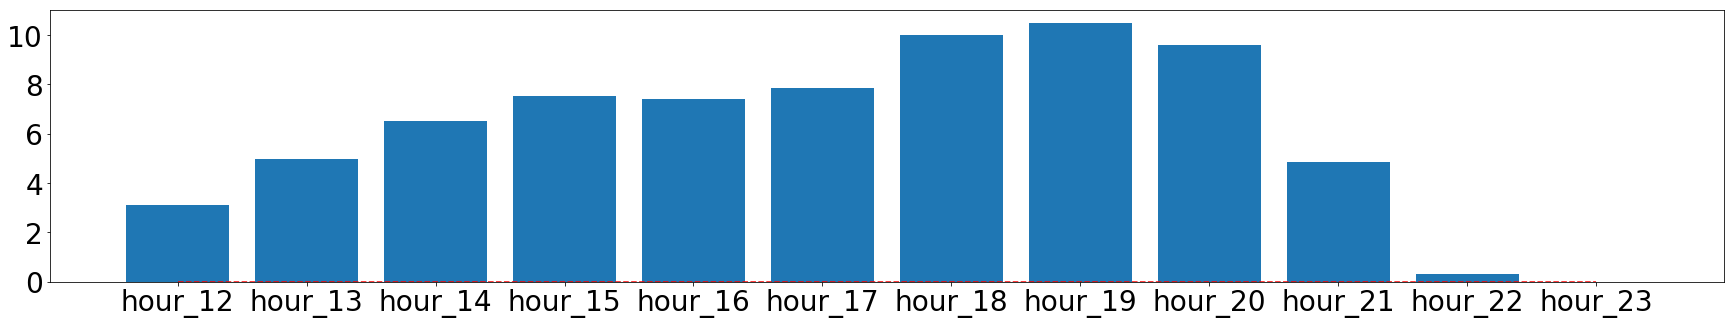

In [43]:
# Interpretation: The orders count increase with the hour between 12pm and 19pm . 
# and then they decrease.

col_names = ['hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
             'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
f, ax = plt.subplots(figsize=(30,5))
plt.bar(col_names, [col_to_coef[key] for key in col_names])
ax.plot(col_names, [0] * len(col_names), "r--")
plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28, rotation=0)

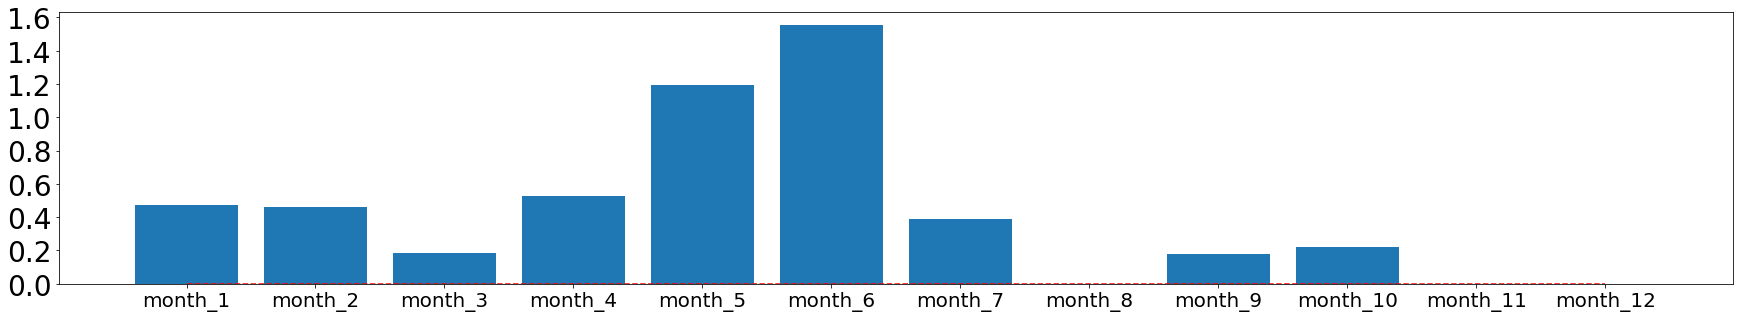

In [46]:
# Interpretation: The months Agust, November and December (winter and summer holidays)
# don't have any impact on the average orders. The highest impact is achieved during spring.

col_names = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
             'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
f, ax = plt.subplots(figsize=(30,5))
plt.bar(col_names, [col_to_coef[key] for key in col_names])
ax.plot(col_names, [0] * len(col_names), "r--")
plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=20, rotation=0)

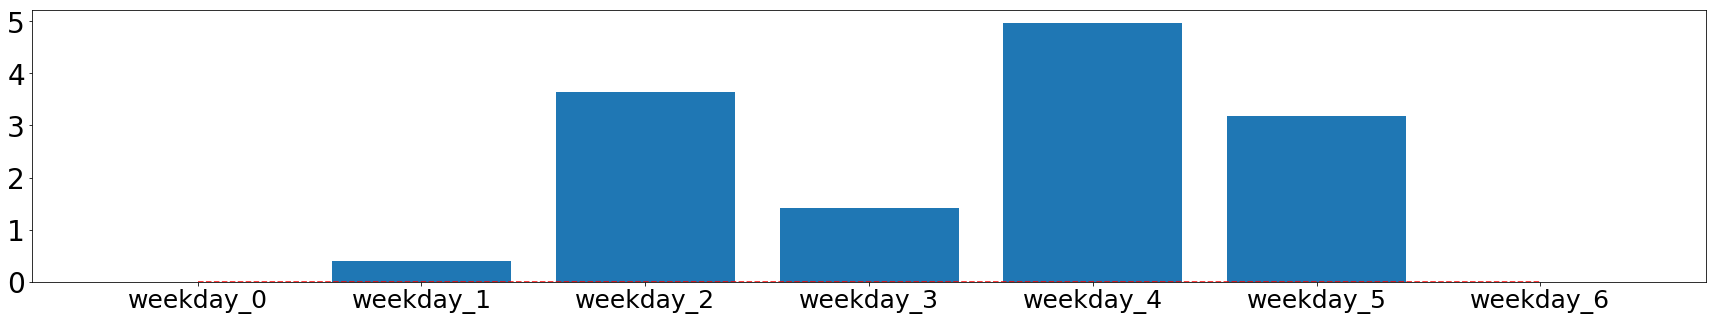

In [47]:
# Interpretation: The days with a largest impact on sales are Wednesday, Friday and Saturday.
# Monday and Sunday don't seem to have any impact on the average sales.

col_names = ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
             'weekday_5', 'weekday_6']
f, ax = plt.subplots(figsize=(30,5))
plt.bar(col_names, [col_to_coef[key] for key in col_names])
ax.plot(col_names, [0] * len(col_names), "r--")
plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=25, rotation=0)

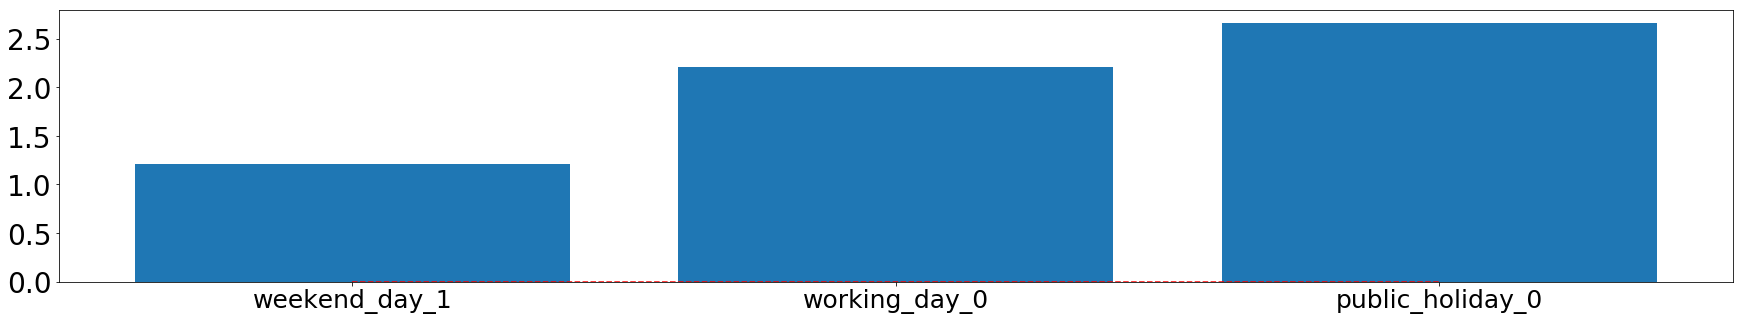

In [49]:
# The highest positive impact on the orders is the fact that the day is not a public holiday.
# Then it has a positive impact also not being a working day (because it is a weekend 
# or a public holiday).

col_names = ['weekend_day_1', 'working_day_0', 'public_holiday_0']
f, ax = plt.subplots(figsize=(30,5))
plt.bar(col_names, [col_to_coef[key] for key in col_names])
ax.plot(col_names, [0] * len(col_names), "r--")
plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=25, rotation=0)

## Random forest model

In [259]:
# Grid search

param_grid = [{'n_estimators': [10, 30, 50], 'max_depth': [10, 20, 30],
               'min_samples_leaf': [10, 20, 30]}]
rfc = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [10, 20, 30], 'n_estimators': [10, 30, 50], 'min_samples_leaf': [10, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='explained_variance', verbose=0)

In [260]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 30}

In [52]:
rfc = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=30, min_samples_leaf=10) 
modelEvaluation(rfc, X_train, y_train, X_test, y_test)

Train data scoring (R2): 0.81
Test data scoring (R2): 0.788
Train data scoring (MSE): 6.74
Test data scoring (MSE): 7.69


In [53]:
sorted_importances = list(sorted(zip(X_train.columns, rfc.feature_importances_),
                                 key= lambda element: element[1], reverse=True))
cols, coefs = zip(*sorted_importances)

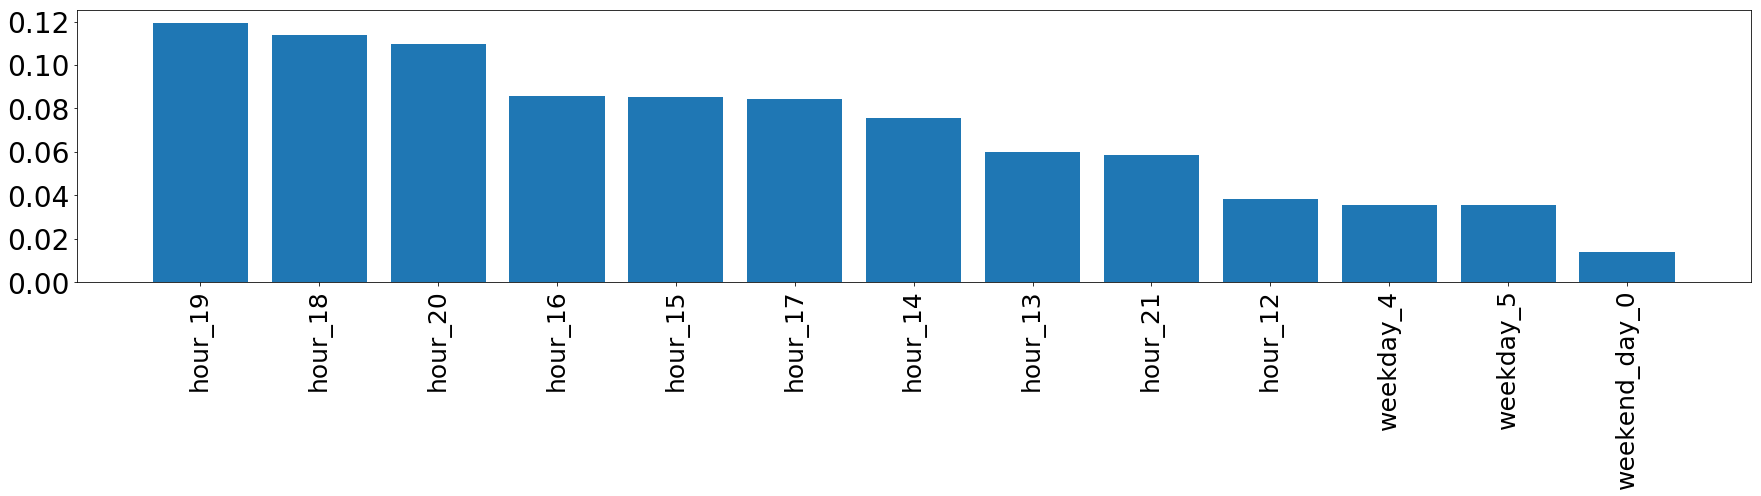

In [59]:
# List of features with highest importance
# We observe that for the predicting the count of orders the schedule
# is the most important predictor. Then the fact if it's Friday or Saturday and finally if 
# it's a weekend day or not.
f, ax = plt.subplots(figsize=(30,5))
plt.bar(cols[:13], coefs[:13])
plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=25, rotation=90)

## Conclusion

* We tested three models to predict the count of pizza orders. For the three models we take care of selecting the right hyper-parameters to avoid overfitting (measure by a small gap between the training and test set performance)
* The model that provides the best results is the random forest. The feature importance analysis also matches with the intuition for this problem.
* Also good results where obtained for the piecewise linear regression model where we introduced the prior information about the opening schedules of the pizza store. The analysis of the regression coefficients also match with our intuition.
* Even though the random forest regressor reaches the best performance, we recommend the use of the piecewise linear regression model because of its better interpretability.  

## Improvements and next steps:

* Add a weather feature to model
* Introduce the piecewise behaviour to the random forest model too.